## Import the libraries

In [17]:
from transformers import AutoTokenizer
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Params

In [20]:
embeddings_dimension = 8 # also known as "hidden_size" in hugginface
num_attention_heads = 2
num_transformer_blocks = 2
max_context_lenght = 25 # also known as "max_position_embeddings" in hugginface
vocab_size = 0 # Set it to zero because it's going to update it later

# Tokenisation

In [22]:
input_text = "SThis is a input textE" # Because its a character leverl tokenizer the SOS is: S and the EOS is: E

# Here w create the Tokenizer
chars = sorted(list(set(input_text)))
vocab_size = len(chars)
print(f"vocab size: {vocab_size}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
tokenize = lambda s: [stoi[c] for c in s] # tokenizer: take a string, output a list of integers
detokenize = lambda l: ''.join([itos[i] for i in l]) # detokenizer: take a list of integers, output a string

vocab size: 14


In [23]:
tokenized_input = tokenize(input_text)
eos_token = tokenized_input[-1]
sos_token = tokenized_input[0]

print(f"eos_token: {eos_token}")
print(f"sos_token: {sos_token}")
print(f"The tokenized Tensor: {tokenized_input}")
print(f"The context size of the current input text is: {len(tokenized_input)}")
print(f"The detokenized Tensor: \"{detokenize(tokenized_input)}\"")

eos_token: 1
sos_token: 2
The tokenized Tensor: [2, 3, 6, 7, 10, 0, 7, 10, 0, 4, 0, 7, 8, 9, 12, 11, 0, 11, 5, 13, 11, 1]
The context size of the current input text is: 22
The detokenized Tensor: "SThis is a input textE"


# Create Embeddings

In [24]:
embedder = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embeddings_dimension, padding_idx=eos_token)
embeddings = embedder(torch.tensor(tokenized_input))

print(f"The shape is: {embeddings.shape}")
print(embeddings)

The shape is: torch.Size([22, 8])
tensor([[ 1.8916, -0.0138, -0.2121,  2.1157, -0.0718, -1.3093,  0.9794,  0.9966],
        [-0.8076,  0.8293,  0.3373,  1.5442,  1.0325,  1.2292,  0.0623, -2.1094],
        [-0.0957, -0.1622,  0.5268,  1.6064, -0.3110, -1.8880, -0.6368, -0.4750],
        [ 1.5842, -0.4195, -1.1202, -0.5330, -0.7852,  0.4069, -1.0324, -0.4364],
        [-1.2373, -0.4454,  1.6577,  0.5674, -1.7532, -0.1483, -1.9084,  1.2612],
        [ 0.3786,  0.9452, -0.3607,  0.0605,  0.8400,  0.5901,  0.2146, -2.7304],
        [ 1.5842, -0.4195, -1.1202, -0.5330, -0.7852,  0.4069, -1.0324, -0.4364],
        [-1.2373, -0.4454,  1.6577,  0.5674, -1.7532, -0.1483, -1.9084,  1.2612],
        [ 0.3786,  0.9452, -0.3607,  0.0605,  0.8400,  0.5901,  0.2146, -2.7304],
        [ 0.0526,  1.1297, -0.2425, -0.5826,  1.0083, -0.3401, -0.7440, -0.2765],
        [ 0.3786,  0.9452, -0.3607,  0.0605,  0.8400,  0.5901,  0.2146, -2.7304],
        [ 1.5842, -0.4195, -1.1202, -0.5330, -0.7852,  0.4069, -

## Create Plot

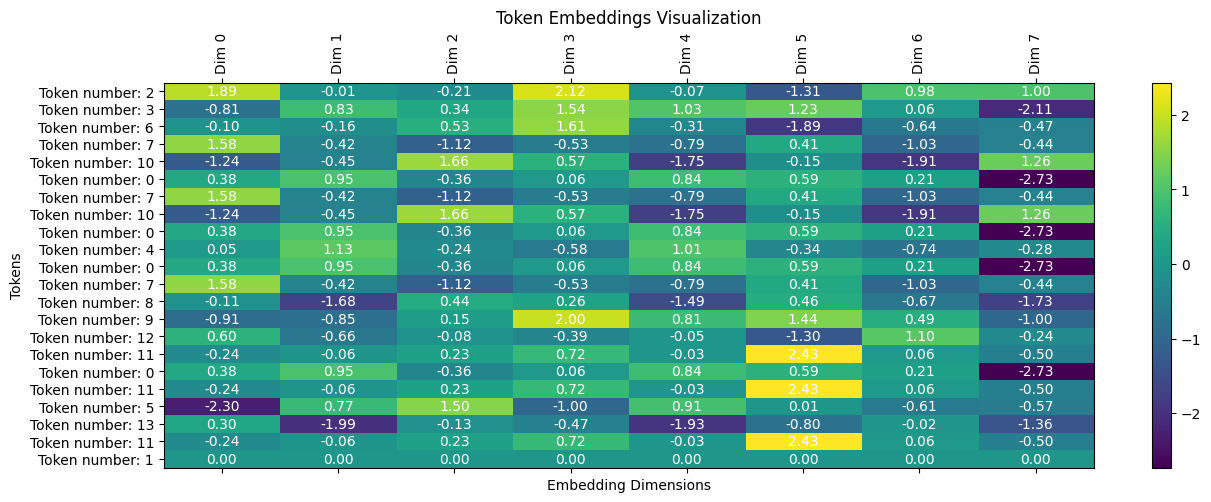

In [26]:
# Convert embeddings to numpy for visualization
embeddings_np = embeddings.detach().numpy()

# Plotting embeddings
fig, ax = plt.subplots(figsize=(15, 5))  # Increase figure size for bigger squares
cax = ax.matshow(embeddings_np, aspect='auto', cmap='viridis')

# Add color bar for reference
fig.colorbar(cax)

# Set labels
ax.set_xticks(np.arange(embeddings_dimension))
ax.set_yticks(np.arange(len(tokenized_input)))
ax.set_xticklabels([f'Dim {i}' for i in range(embeddings_dimension)])
ax.set_yticklabels([f'Token number: {i}' for i in tokenized_input])

# Rotate the tick labels and set their alignment
plt.xticks(rotation=90)
plt.xlabel('Embedding Dimensions')
plt.ylabel('Tokens')

# Adding numerical values to the plot
for i in range(len(tokenized_input)):
    for j in range(embeddings_dimension):
        text = ax.text(j, i, f'{embeddings_np[i, j]:.2f}', ha='center', va='center', color='white')

plt.title('Token Embeddings Visualization')
plt.show()